# Graph Neural Networks for Physics Simulations: A Visual Guide

This notebook provides a comprehensive introduction to Graph Neural Networks (GNNs) with a focus on physics simulation applications, specifically Smoothed Particle Hydrodynamics (SPH). We'll start from basic concepts and build up to a complete implementation.

## Prerequisites
- Basic understanding of PyTorch and neural networks
- Familiarity with physics simulation concepts
- Python programming experience

## What You'll Learn
1. Understanding graphs in the context of GNNs
2. How to construct graphs from spatial/physics data
3. The message passing mechanism in GNNs
4. Differences between static and dynamic graphs
5. Building a complete pipeline from simulation data to predictions

First, make sure you have all required packages installed:
```bash
pip install torch torch_geometric matplotlib networkx numpy ipywidgets
```

In [4]:
%pip install torch torch_geometric matplotlib networkx numpy ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.1 MB ? eta -:--:--Downloading torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.1 MB ? eta -:--:--Downloading matplotlib-3.10.3-cp312-cp312-macosx_11_0_arm64.whl (8.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 10.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.7 MB ? eta -:--:--Downloading cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.7 MB/s eta 0:00:00a 0:00:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.2 MB ? eta -:

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ipywidgets import interact, FloatSlider

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Enable interactive plots
%matplotlib inline

## Section 1: Graph Basics - From Particles to Graphs

In physics simulations, particularly in SPH (Smoothed Particle Hydrodynamics), we often work with particles in space. These particles interact with their neighbors based on their spatial proximity. This is where graphs come in!

Key insight: **The graph structure is not part of your training data - you create it from particle positions!**

Let's start with a simple example using 5 particles in 2D space. We'll create an interactive visualization that shows how the graph structure emerges from particle positions based on a neighbor radius.

In [6]:
def generate_random_particles(n_particles=5, seed=42):
    """Generate random 2D particle positions"""
    np.random.seed(seed)
    return np.random.rand(n_particles, 2) * 3.0

def compute_edges(positions, radius):
    """Compute edges between particles within radius"""
    n_particles = len(positions)
    edges = []
    
    for i in range(n_particles):
        for j in range(i+1, n_particles):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist <= radius:
                edges.append((i, j))
    
    return edges

def visualize_particle_graph(positions, radius):
    """Visualize particles and their connections"""
    edges = compute_edges(positions, radius)
    
    # Create graph
    G = nx.Graph()
    for i in range(len(positions)):
        G.add_node(i, pos=positions[i])
    G.add_edges_from(edges)
    
    # Setup plot
    plt.figure(figsize=(10, 10))
    plt.axis('equal')
    
    # Draw edges
    pos = {i: pos for i, pos in enumerate(positions)}
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    
    # Draw nodes
    plt.scatter(positions[:, 0], positions[:, 1], s=200, c='lightblue', 
                edgecolor='black', zorder=2)
    
    # Draw node labels
    for i, (x, y) in enumerate(positions):
        plt.annotate(f'P{i}\n({x:.1f}, {y:.1f})', (x, y), 
                     xytext=(5, 5), textcoords='offset points')
    
    # Draw radius circle for first particle
    circle = plt.Circle(positions[0], radius, fill=False, ls='--', alpha=0.3)
    plt.gca().add_patch(circle)
    
    plt.title(f'Particle Graph (radius = {radius:.2f})')
    plt.axis([0, 3, 0, 3])
    plt.grid(True, alpha=0.3)
    plt.show()

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


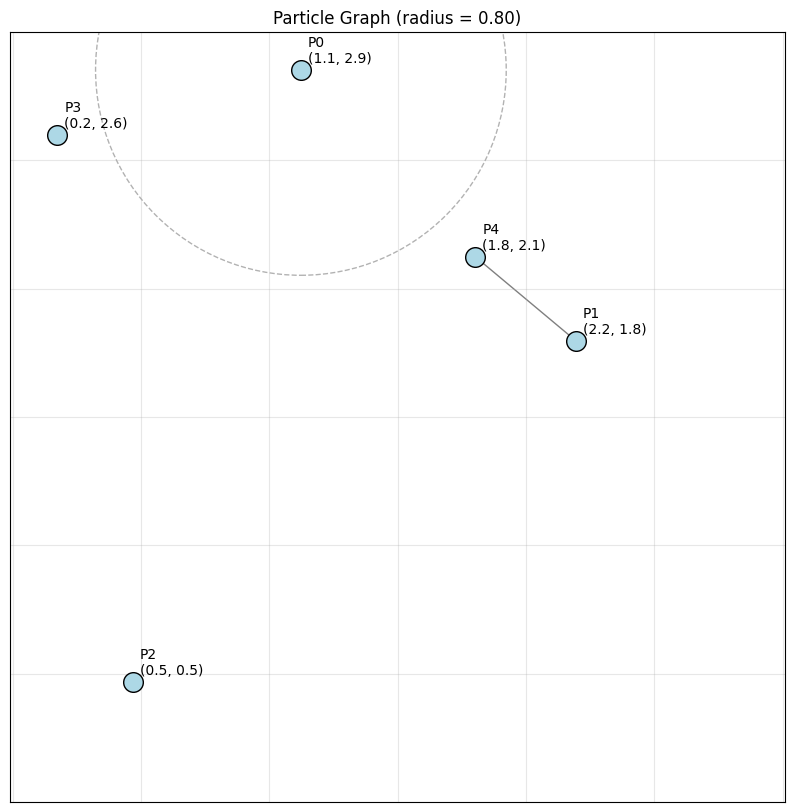

In [8]:
visualize_particle_graph(fixed_positions, radius=0.8)

In [9]:
# Generate fixed particle positions
fixed_positions = generate_random_particles()

# Create interactive slider
@interact(radius=FloatSlider(min=0.2, max=2.0, step=0.1, value=0.8))
def update_visualization(radius):
    visualize_particle_graph(fixed_positions, radius)

interactive(children=(FloatSlider(value=0.8, description='radius', max=2.0, min=0.2), Output()), _dom_classes=…

### Understanding the Visualization

- Each blue circle represents a particle with its 2D coordinates
- The dashed circle shows the neighbor radius around particle P0
- Black lines show connections (edges) between particles within radius
- As you adjust the radius slider:
  - Larger radius → more connections
  - Smaller radius → fewer connections

**Key Points:**
1. The graph structure (connections) is computed purely from particle positions
2. We only connect particles within the specified radius
3. This radius is a hyperparameter you can tune
4. The graph changes if particles move or if you change the radius

## Section 2: From Positions to Graph - Implementation Details

Now let's look at how to convert particle positions into a graph format that PyTorch Geometric can understand. We'll implement this step-by-step, showing exactly how `edge_index` is created.

### Key Concepts:
- `edge_index`: A (2 × num_edges) tensor containing pairs of connected nodes
- Each column in `edge_index` represents a directed edge [source_node, target_node]
- For undirected graphs, we need both [i, j] and [j, i] edges

In [13]:
def build_neighbor_graph(positions, radius):
    """Convert particle positions into PyG graph connectivity
    
    Args:
        positions (torch.Tensor): (N x 2) tensor of particle positions
        radius (float): Radius for connecting neighboring particles
        
    Returns:
        edge_index (torch.Tensor): (2 x E) tensor of connected particle indices
    """
    # Convert positions to tensor if needed
    if not torch.is_tensor(positions):
        positions = torch.tensor(positions, dtype=torch.float)
    
    # Number of particles
    n_particles = positions.size(0)
    
    # Step 1: Compute pairwise distances between all particles
    # Reshape positions for broadcasting
    pos_i = positions.unsqueeze(1)  # (N, 1, 2)
    pos_j = positions.unsqueeze(0)  # (1, N, 2)
    
    # Compute distances: Note the broadcasting!
    distances = torch.norm(pos_i - pos_j, dim=2)  # (N, N)
    
    # Step 2: Find pairs within radius (excluding self-connections)
    # Create mask for valid connections
    connections = (distances <= radius) & (distances > 0)  # Exclude self-loops
    
    # Step 3: Convert to edge_index format
    # Get indices of True values in the mask
    edges = torch.nonzero(connections, as_tuple=False)  # (E, 2)
    
    # Convert to PyG's expected format (2, E)
    edge_index = edges.t().contiguous()
    
    return edge_index

Positions:
 tensor([[1.0000, 2.0000],
        [1.2000, 1.8000],
        [0.8000, 2.1000]])

Edge Index:
 tensor([[0, 0, 1, 1, 2, 2],
        [1, 2, 0, 2, 0, 1]])


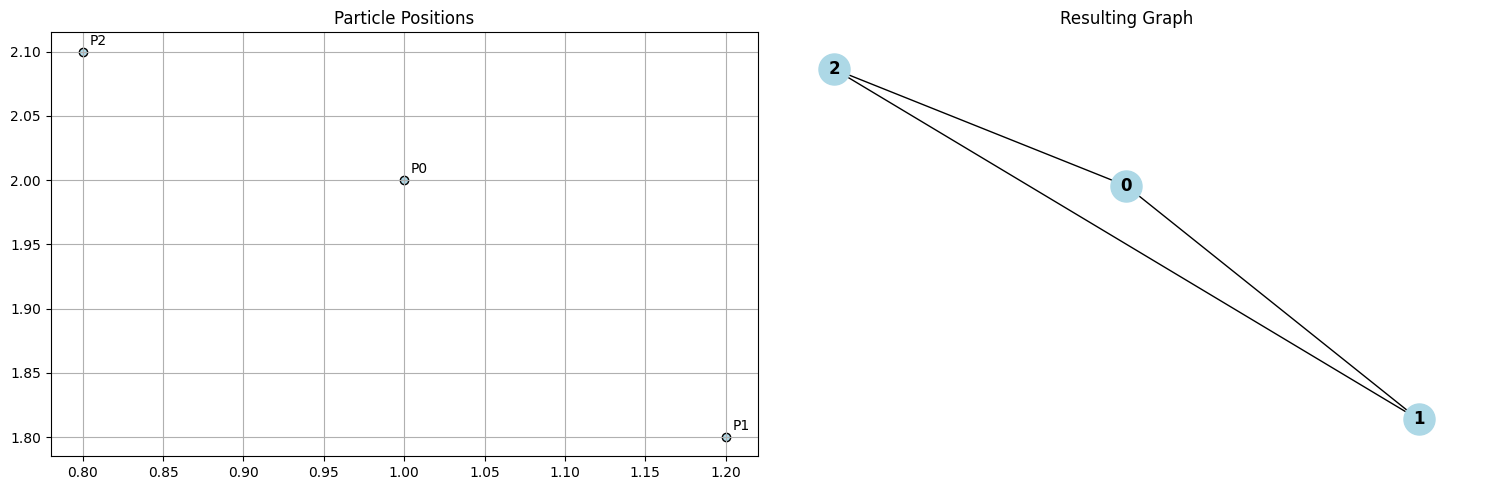

In [14]:
# Example usage with our previous particles
positions = torch.tensor([
    [1.0, 2.0],  # Particle 0
    [1.2, 1.8],  # Particle 1
    [0.8, 2.1]   # Particle 2
], dtype=torch.float)

radius = 0.5
edge_index = build_neighbor_graph(positions, radius)

print("Positions:\n", positions)
print("\nEdge Index:\n", edge_index)

# Visualize the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot positions
ax1.scatter(positions[:, 0], positions[:, 1], c='lightblue', edgecolor='black')
for i, (x, y) in enumerate(positions):
    ax1.annotate(f'P{i}', (x, y), xytext=(5, 5), textcoords='offset points')
ax1.set_title('Particle Positions')
ax1.grid(True)

# Plot graph structure
G = nx.Graph()
for i in range(len(positions)):
    G.add_node(i, pos=positions[i].numpy())
for e in edge_index.t():
    G.add_edge(e[0].item(), e[1].item())
    
pos = {i: pos.numpy() for i, pos in enumerate(positions)}
nx.draw(G, pos, ax=ax2, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=12, font_weight='bold')
ax2.set_title('Resulting Graph')

plt.tight_layout()
plt.show()

### Understanding the Implementation

1. **Input**: Raw particle positions and a radius
2. **Step-by-step process**:
   - Compute pairwise distances between all particles
   - Create a boolean mask for particles within radius
   - Convert the mask to edge indices
   - Format as PyTorch Geometric expects (2×E tensor)

3. **Efficiency considerations**:
   - Uses broadcasting for distance computation
   - Avoids loops over particles
   - Memory efficient for small-to-medium sized systems

4. **Common gotchas**:
   - Remember to exclude self-loops (particle connected to itself)
   - Use contiguous tensors for PyG compatibility
   - Handle both numpy arrays and torch tensors as input

## Section 3: Message Passing - Under the Hood

Now that we understand how to create graphs from particle positions, let's dive into how Graph Neural Networks process this data. We'll implement message passing from scratch to understand what's happening under the hood.

### What is Message Passing?
1. Each particle (node) has features (position, velocity, etc.)
2. Particles exchange information with their neighbors
3. Information is transformed and aggregated
4. Each particle updates its features based on the aggregated messages

In [15]:
class ManualMessagePassing:
    def __init__(self, feature_size):
        # Simple linear transformations for message and update functions
        self.message_weights = torch.randn(feature_size, feature_size)
        self.update_weights = torch.randn(2 * feature_size, feature_size)
    
    def compute_messages(self, node_features, edge_index):
        """Compute messages between connected particles"""
        # Get features of source nodes for each edge
        source_features = node_features[edge_index[0]]
        
        # Transform features to create messages
        messages = torch.mm(source_features, self.message_weights)
        
        return messages
    
    def aggregate_messages(self, messages, edge_index, num_nodes):
        """Aggregate messages for each target node"""
        # Initialize aggregated messages
        aggregated = torch.zeros(num_nodes, messages.size(1))
        
        # Sum messages for each target node
        target_idx = edge_index[1]
        aggregated.index_add_(0, target_idx, messages)
        
        return aggregated
    
    def update_nodes(self, node_features, aggregated_messages):
        """Update node features based on aggregated messages"""
        # Concatenate node features with aggregated messages
        combined = torch.cat([node_features, aggregated_messages], dim=1)
        
        # Transform to get updated features
        updated = torch.mm(combined, self.update_weights)
        
        return updated
    
    def forward(self, node_features, edge_index):
        """Complete message passing step"""
        messages = self.compute_messages(node_features, edge_index)
        aggregated = self.aggregate_messages(messages, edge_index, 
                                           num_nodes=node_features.size(0))
        updated = self.update_nodes(node_features, aggregated)
        
        return updated

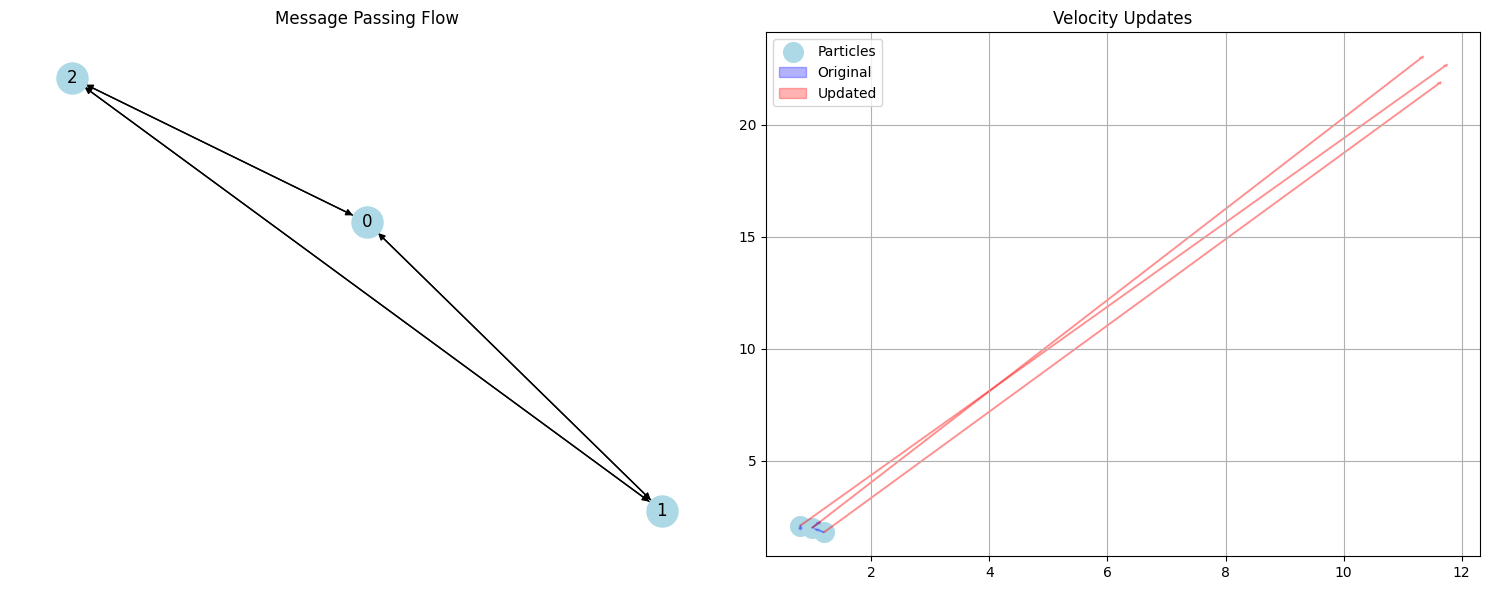

In [16]:
# Example with our 3 particles
node_features = torch.tensor([
    [1.0, 2.0, 0.1, 0.2],  # Particle 0: [x, y, vx, vy]
    [1.2, 1.8, -0.1, 0.1],  # Particle 1
    [0.8, 2.1, 0.0, -0.1]   # Particle 2
], dtype=torch.float)

# Create message passing layer
mp_layer = ManualMessagePassing(feature_size=4)

# Compute one step
updated_features = mp_layer.forward(node_features, edge_index)

# Visualize the process
def visualize_message_passing(node_features, edge_index, updated_features):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    pos = {i: node_features[i, :2].numpy() for i in range(len(node_features))}
    
    # Before update
    G = nx.DiGraph()
    for i in range(len(node_features)):
        G.add_node(i)
    for i, j in edge_index.t():
        G.add_edge(i.item(), j.item())
    
    nx.draw(G, pos, ax=ax1, with_labels=True, node_color='lightblue',
            node_size=500, font_size=12, arrows=True)
    ax1.set_title('Message Passing Flow')
    
    # After update
    velocities = node_features[:, 2:]
    updated_velocities = updated_features[:, 2:]
    
    ax2.scatter(node_features[:, 0], node_features[:, 1], 
                c='lightblue', s=200, label='Particles')
    
    # Plot velocity vectors
    for i in range(len(node_features)):
        # Original velocity
        ax2.arrow(node_features[i, 0], node_features[i, 1],
                  velocities[i, 0], velocities[i, 1],
                  color='blue', alpha=0.3, width=0.02,
                  label='Original' if i == 0 else None)
        
        # Updated velocity
        ax2.arrow(node_features[i, 0], node_features[i, 1],
                  updated_velocities[i, 0], updated_velocities[i, 1],
                  color='red', alpha=0.3, width=0.02,
                  label='Updated' if i == 0 else None)
    
    ax2.legend()
    ax2.set_title('Velocity Updates')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

visualize_message_passing(node_features, edge_index, updated_features)

### Understanding Message Passing

1. **Message Computation**
   - Each particle looks at its neighbors' features
   - Creates a message using a learned transformation
   - Messages contain relevant information for interaction

2. **Message Aggregation**
   - Each particle collects messages from its neighbors
   - Messages are combined (summed in this case)
   - Result captures neighborhood information

3. **Node Update**
   - Each particle combines its current features with aggregated messages
   - Applies another learned transformation
   - Results in updated particle features

**Key Insights:**
- Message passing naturally handles varying numbers of neighbors
- The process is permutation invariant (order of neighbors doesn't matter)
- All computations are differentiable (can be trained end-to-end)
- This is just one message passing step - deep GNNs stack multiple layers

## Section 4: Complete SPH Example

Now let's put everything together in a complete example using PyTorch Geometric. We'll:
1. Generate simple SPH simulation data
2. Create a GNN model for predicting particle dynamics
3. Show how the graph structure updates as particles move

Our goal is to predict the next timestep's particle positions based on current positions and velocities.

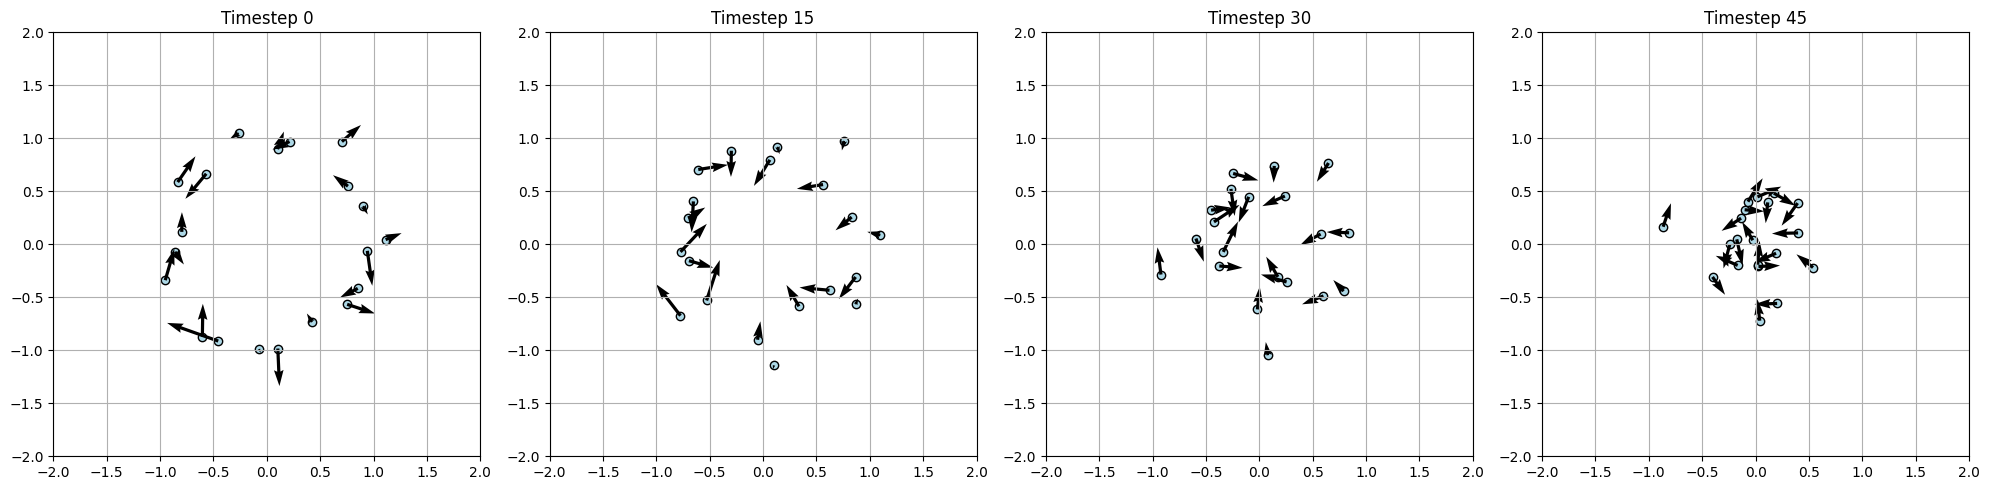

In [17]:
def generate_sph_data(n_particles=20, n_timesteps=50, dt=0.1):
    """Generate simple SPH simulation data"""
    # Initialize particles in a circle with random velocities
    theta = np.linspace(0, 2*np.pi, n_particles) + np.random.randn(n_particles)*0.1
    r = 1.0 + np.random.randn(n_particles)*0.1
    
    positions = []
    velocities = []
    
    # Initial state
    pos = np.stack([r*np.cos(theta), r*np.sin(theta)], axis=1)
    vel = np.random.randn(n_particles, 2) * 0.1
    
    for t in range(n_timesteps):
        # Simple physics: add central force
        acc = -0.1 * pos  # Attraction to center
        vel = vel + acc * dt
        pos = pos + vel * dt
        
        positions.append(pos.copy())
        velocities.append(vel.copy())
    
    return np.stack(positions), np.stack(velocities)

# Generate data
positions, velocities = generate_sph_data()

# Visualize a few timesteps
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, t in enumerate([0, 15, 30, 45]):
    ax = axes[i]
    ax.scatter(positions[t, :, 0], positions[t, :, 1], c='lightblue', 
               edgecolor='black')
    ax.quiver(positions[t, :, 0], positions[t, :, 1],
              velocities[t, :, 0], velocities[t, :, 1])
    ax.set_title(f'Timestep {t}')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.grid(True)

plt.tight_layout()
plt.show()

In [18]:
class ParticleDynamicsGNN(MessagePassing):
    def __init__(self, in_channels):
        super().__init__(aggr='add')  # Use sum aggregation
        self.in_channels = in_channels
        
        # MLPs for transformations
        self.message_mlp = nn.Sequential(
            nn.Linear(2 * in_channels, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        self.update_mlp = nn.Sequential(
            nn.Linear(32 + in_channels, 32),
            nn.ReLU(),
            nn.Linear(32, in_channels)
        )
        
    def forward(self, x, edge_index, edge_attr=None):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]
        
        return self.propagate(edge_index, x=x)
    
    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]
        
        # Concatenate features of source and target nodes
        inputs = torch.cat([x_i, x_j], dim=1)
        
        # Transform to create messages
        return self.message_mlp(inputs)
    
    def update(self, aggr_out, x):
        # aggr_out has shape [N, 32]
        # x has shape [N, in_channels]
        
        # Concatenate node features with aggregated messages
        inputs = torch.cat([aggr_out, x], dim=1)
        
        # Transform to create new node features
        return self.update_mlp(inputs)

Epoch 10, Loss: 0.000417
Epoch 20, Loss: 0.000114
Epoch 30, Loss: 0.000063
Epoch 40, Loss: 0.000235
Epoch 50, Loss: 0.000068
Epoch 60, Loss: 0.000034
Epoch 70, Loss: 0.001513
Epoch 80, Loss: 0.000056
Epoch 90, Loss: 0.000019
Epoch 100, Loss: 0.000011


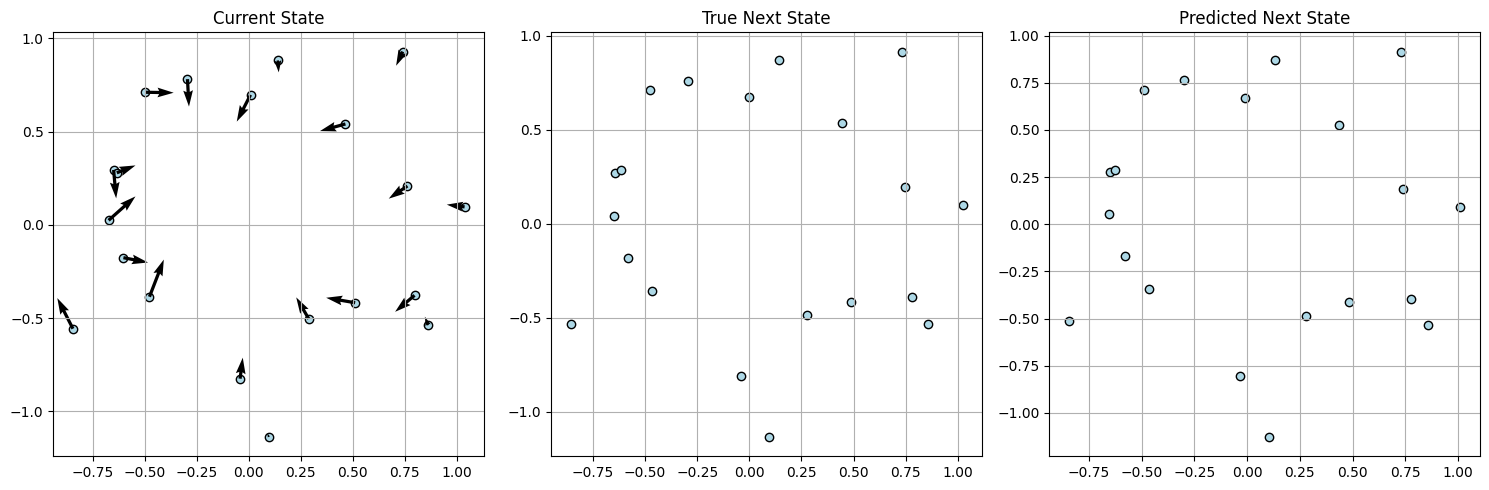

In [19]:
# Convert data to PyTorch tensors
X = torch.tensor(np.concatenate([positions[:-1], velocities[:-1]], axis=2), 
                dtype=torch.float)
y = torch.tensor(positions[1:], dtype=torch.float)

# Create model and optimizer
model = ParticleDynamicsGNN(in_channels=4)  # 2 for position + 2 for velocity
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(100):
    total_loss = 0
    for t in range(len(X)):
        # Build graph for current timestep
        pos_t = X[t, :, :2]
        edge_index = build_neighbor_graph(pos_t, radius=0.5)
        
        # Forward pass
        pred = model(X[t], edge_index)
        loss = F.mse_loss(pred[:, :2], y[t])  # Only predict positions
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(X):.6f}')

# Visualize predictions
def visualize_predictions(model, X, y, timestep=0):
    model.eval()
    pos_t = X[timestep, :, :2]
    edge_index = build_neighbor_graph(pos_t, radius=0.5)
    
    with torch.no_grad():
        pred = model(X[timestep], edge_index)
    
    plt.figure(figsize=(15, 5))
    
    # Plot current timestep
    plt.subplot(131)
    plt.scatter(pos_t[:, 0], pos_t[:, 1], c='lightblue', edgecolor='black')
    plt.quiver(pos_t[:, 0], pos_t[:, 1],
               X[timestep, :, 2], X[timestep, :, 3])
    plt.title('Current State')
    plt.grid(True)
    
    # Plot true next state
    plt.subplot(132)
    plt.scatter(y[timestep, :, 0], y[timestep, :, 1], 
                c='lightblue', edgecolor='black')
    plt.title('True Next State')
    plt.grid(True)
    
    # Plot predicted next state
    plt.subplot(133)
    plt.scatter(pred[:, 0].numpy(), pred[:, 1].numpy(), 
                c='lightblue', edgecolor='black')
    plt.title('Predicted Next State')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, X, y, timestep=20)

### Understanding the Implementation

1. **Data Generation**
   - Created simple particle system with central force
   - Each particle has position and velocity
   - System evolves over time

2. **GNN Architecture**
   - Uses PyTorch Geometric's MessagePassing base class
   - MLPs for message and update functions
   - Predicts next timestep positions

3. **Dynamic Graph Construction**
   - Graph is rebuilt at each timestep
   - Uses our `build_neighbor_graph` function
   - Connections change as particles move

4. **Training Process**
   - MSE loss between predicted and true positions
   - Model learns particle interactions
   - Can generalize to different initial conditions

This example shows how GNNs can learn physical dynamics while handling varying numbers of neighbors and respecting particle symmetries!

## Section 5: Common Confusions Addressed

### 1. "Where does edge_index come from?"

The `edge_index` tensor is **not** part of your training data! It is computed from particle positions at each timestep:

```python
pos_t = current_positions
edge_index = build_neighbor_graph(pos_t, radius=0.5)
```

We saw exactly how this works in Section 2, where we implemented the `build_neighbor_graph` function.

### 2. "Is the graph part of the training data?"

No! The graph structure is derived from particle positions. Think of it as a computational step:
1. Get particle positions
2. Compute distances between particles
3. Create edges between nearby particles
4. Use this graph structure for one forward pass
5. Repeat for next timestep

### 3. "Why rebuild graphs each timestep?"

In physics simulations, particles move! This means:
- Particle A's neighbors at t=0 might be different at t=1
- The graph structure must reflect current particle positions
- We can't use a static graph like in social networks

Here's the key difference:
- **Static graphs** (e.g., social networks): Graph structure is fixed
- **Dynamic graphs** (e.g., physics): Graph changes with particle motion

### 4. "How is this different from CNNs?"

CNNs vs GNNs for particle systems:

**CNNs:**
- Fixed grid structure
- Same connections for every sample
- Can't easily handle varying numbers of particles
- Wasteful for sparse particle distributions

**GNNs:**
- Flexible graph structure
- Connections based on particle positions
- Naturally handle varying particle counts
- Efficient for sparse systems

### 5. Debug Common Issues

1. **No edges found:**
   - Check if radius is too small
   - Verify particle positions are in expected range
   - Ensure units are consistent

2. **Training instability:**
   - Graph structure changing too much between steps?
   - Try smaller time steps
   - Adjust radius or add momentum to predictions

3. **Poor predictions:**
   - Increase model capacity (wider/deeper MLPs)
   - Add more physics-informed features
   - Consider multi-scale radius approach

In [20]:
# Interactive visualization of dynamic graphs
def visualize_dynamic_graph(positions, velocities, radius):
    """Show how graph structure changes over time"""
    t = slider.value
    
    plt.figure(figsize=(10, 10))
    
    # Current positions and velocities
    pos_t = positions[t]
    vel_t = velocities[t]
    
    # Compute graph structure
    edge_index = build_neighbor_graph(torch.tensor(pos_t), radius)
    
    # Plot particles
    plt.scatter(pos_t[:, 0], pos_t[:, 1], c='lightblue', 
                s=200, edgecolor='black', zorder=2)
    
    # Plot velocities
    plt.quiver(pos_t[:, 0], pos_t[:, 1], vel_t[:, 0], vel_t[:, 1],
               scale=20, color='blue', alpha=0.5)
    
    # Plot edges
    for i, j in edge_index.t():
        i, j = i.item(), j.item()
        plt.plot([pos_t[i, 0], pos_t[j, 0]],
                 [pos_t[i, 1], pos_t[j, 1]],
                 'k-', alpha=0.3, zorder=1)
    
    plt.title(f'Timestep {t}: {edge_index.size(1)} edges')
    plt.grid(True)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    
# Create time slider
slider = FloatSlider(min=0, max=len(positions)-1, 
                     step=1, value=0, description='Time')

# Create radius slider
radius_slider = FloatSlider(min=0.1, max=1.0, 
                           step=0.1, value=0.5, description='Radius')

@interact(t=slider, radius=radius_slider)
def update(t, radius):
    visualize_dynamic_graph(positions, velocities, radius)

interactive(children=(FloatSlider(value=0.0, description='Time', max=49.0, step=1.0), FloatSlider(value=0.5, d…

<Figure size 1000x1000 with 0 Axes>

## Summary

In this tutorial, we've learned:

1. **Graph Construction**
   - How to build graphs from particle positions
   - Why dynamic graph construction is necessary
   - Efficient implementation techniques

2. **Message Passing**
   - Core mechanism of GNNs
   - How particles exchange information
   - Implementation from scratch and with PyG

3. **Physics Simulation**
   - Complete pipeline from positions to predictions
   - Handling dynamic graphs
   - Training strategies for particle systems

4. **Best Practices**
   - Start simple (few particles, 2D)
   - Visualize every step
   - Debug common issues

Now you're ready to apply GNNs to your own physics problems! Remember: the graph is not your data - it's a computational structure you create to enable flexible particle interactions.

In [22]:
import h5py
import numpy as np
import torch

def explore_h5_structure(filepath):
    """Explore the structure of an H5 file to understand what data is available"""
    print(f"Exploring structure of: {filepath}")
    print("=" * 50)
    
    with h5py.File(filepath, 'r') as f:
        print("Top-level keys:", list(f.keys()))
        print()
        
        def print_item_info(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name}")
                print(f"  Shape: {obj.shape}")
                print(f"  Type: {obj.dtype}")
                print(f"  Size: {obj.size} elements")
                if obj.size < 10:  # Show small datasets
                    print(f"  Data: {obj[:].tolist()}")
                print()
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")
                print(f"  Contains: {list(obj.keys())}")
                print()
        
        f.visititems(print_item_info)

# Explore your dataset structure first
explore_h5_structure('/Volumes/Meida/01-CodeLab/01-personal-project/2D_DAM_5740_20kevery100/train.h5')

Exploring structure of: /Volumes/Meida/01-CodeLab/01-personal-project/2D_DAM_5740_20kevery100/train.h5
Top-level keys: ['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049']

Group: 00000
  Contains: ['particle_type', 'position']

Dataset: 00000/particle_type
  Shape: (5740,)
  Type: int64
  Size: 5740 elements

Dataset: 00000/position
  Shape: (401, 5740, 2)
  Type: float32
  Size: 4603480 elements

Group: 00001
  Contains: ['particle_type', 'position']

Dataset: 00001/particle_type
  Shape: (5740,)
  Type: int64
  Size: 5740 elements

Dataset: 00001/position
  Shape: (401, 5740, 2)
  Type: float

Loading 5 episodes from /Volumes/Meida/01-CodeLab/01-personal-project/2D_DAM_5740_20kevery100/train.h5
Loaded positions shape: torch.Size([5, 401, 5740, 2])
Loaded particle types shape: torch.Size([5, 5740])
Position range: 0.05000000074505806 to 5.435999870300293
Particle types: tensor([0, 1])


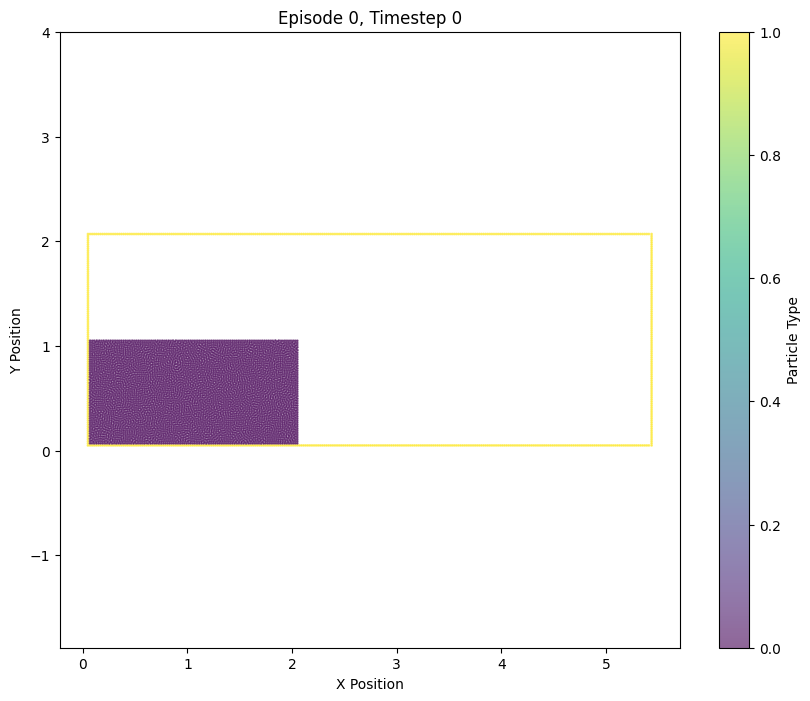

In [23]:
def load_h5_dataset(filepath, max_episodes=None):
    """Load SPH dataset from H5 file"""
    with h5py.File(filepath, 'r') as f:
        episodes = list(f.keys())
        if max_episodes:
            episodes = episodes[:max_episodes]
        
        print(f"Loading {len(episodes)} episodes from {filepath}")
        
        all_positions = []
        all_particle_types = []
        
        for episode_id in episodes:
            # Load position data: (timesteps, particles, 2)
            positions = torch.tensor(f[f'{episode_id}/position'][:], dtype=torch.float32)
            particle_types = torch.tensor(f[f'{episode_id}/particle_type'][:], dtype=torch.long)
            
            all_positions.append(positions)
            all_particle_types.append(particle_types)
            
        # Stack all episodes
        positions = torch.stack(all_positions)  # (episodes, timesteps, particles, 2)
        particle_types = torch.stack(all_particle_types)  # (episodes, particles)
        
        print(f"Loaded positions shape: {positions.shape}")
        print(f"Loaded particle types shape: {particle_types.shape}")
        
        return positions, particle_types

# Load your datasets (start with a few episodes for testing)
train_pos, train_types = load_h5_dataset('/Volumes/Meida/01-CodeLab/01-personal-project/2D_DAM_5740_20kevery100/train.h5', 
                                          max_episodes=5)

# Check the data
print("Position range:", train_pos.min().item(), "to", train_pos.max().item())
print("Particle types:", torch.unique(train_types))

# Visualize one timestep
episode = 0
timestep = 0
pos_sample = train_pos[episode, timestep]  # Shape: (5740, 2)

plt.figure(figsize=(10, 8))
plt.scatter(pos_sample[:, 0], pos_sample[:, 1], c=train_types[episode], 
            s=1, cmap='viridis', alpha=0.6)
plt.colorbar(label='Particle Type')
plt.title(f'Episode {episode}, Timestep {timestep}')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.axis('equal')
plt.show()